# Table of Contents
* [Imports](#Imports)


* [Functions](#Functions)


* [Read in and filter](#Read-in-and-filter)


* [Model: TESTING vs jobs simultaneously running](#Model:-TESTING-vs-jobs-simultaneously-running)
    * [Make the model](#Make-the-model)
    * [Plot the model](#Plot-the-model)
    * [Check the model's calibration](#Check-the-model's-calibration)
    * [Look for any thresholds where unresponsiveness jumps](#Look-for-any-thresholds-where-unresponsiveness-jumps)
    * [Identifying the maximum predicted probability of unresponsiveness from the observed data](#Identifying-the-maximum-predicted-probability-of-unresponsiveness)
    
    
 * [Follow-up: So when do we have a lot of jobs running?](#Follow-up:-So-when-do-we-have-a-lot-of-jobs-running?)
     * [Mean of jobs simultaneously running](#Mean-of-jobs-simultaneously-running)
     * [Seasonal/Yearlong by week](#Seasonal/Yearlong-by-week)
     * [Use weeks to estimate whether jobs running has increased on average](#Use-weeks-to-estimate-whether-jobs-running-has-increased-on-average)
     * [Days](#Days)
     * [Weekdays](#Weekdays)
     * [Time of day](#Time-of-day)
     
     
* [Table of Contents (again)](#Table-of-Contents-(again))

# Imports

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import re
from jupyterthemes import jtplot
from datetime import timedelta, datetime
import calendar
import plotly.express as px
import sklearn.calibration
jtplot.style()

# Functions

Create rolling window of jobs begun or ended in hour prior to each test, or get number of jobs running at the time of each test.

In [68]:
def rollmodel_df(x, dt_col, jobs_running = False, filter_jobs = True):
    y = x.rename(columns = {'DATETIME' : dt_col}).drop(columns = ['JOBID'])
    df = pd.concat([slurm_jobs, y])
    df = df.sort_values(dt_col).reset_index(drop = True)
    if jobs_running == True:
        
        begin_load_df = (df[~df['JOBID'].isnull()]
                                  [['BEGIN']]
                                  .rename(columns={'BEGIN':'TIME'})
                        )
        begin_load_df['process'] = 1
        
        end_load_df = (df[~df['JOBID'].isnull()]
                                  [['END']]
                                  .rename(columns={'END':'TIME'})
                      )
        end_load_df['process'] = -1 
        
        commands_load_df = (df[df['JOBID'].isnull()]
                                  [[dt_col]]
                                  .rename(columns={dt_col:'TIME'})
                      )
        commands_load_df['process'] = 0 
        
        load_df = begin_load_df.append(end_load_df).append(commands_load_df)
        jobs_running_prefilter = load_df.sort_values('TIME')['process'].cumsum()
        jobs_running = jobs_running_prefilter[~jobs_running_prefilter
                                                  .index
                                                  .duplicated(keep='first')]
        df['JOBSRUNNING'+dt_col] = jobs_running
    else:
        df['ROLL1HR'+dt_col] = (df
                                   .rolling('1h', on = dt_col)
                                    ['JOBID']
                                    .count()
                                )
    if filter_jobs == True:
        df = df[df['JOBID'].isnull()]
    else:
        pass
    df = df[(df[dt_col] < '2021-05-18') | (df[dt_col] >= '2021-06-01')]
    return df

Logistic (unwraps Logit)

In [69]:
def logistic(x, a, b):
    return 1/(1+np.exp(-(a + (b*x))))

# Read in and filter

## ce dataframe

In [70]:
ce = pd.read_csv('../data/ce.csv')

In [71]:
# Set some datatypes
ce['DATETIME'] = pd.to_datetime(ce['DATETIME'])
ce['UNRESPONSIVE'] = ce['UNRESPONSIVE'].astype('boolean')

## slurm_jobs dataframe
We remove ROLL1HR because we want those values to roll over the *testing* values that we'll concatenate in.

In [73]:
slurm_jobs = pd.read_csv('../data/slurm_jobs.csv')

In [74]:
# Set our datetimes and timedeltas
datetime_cols = ['BEGIN', 'END']
for col in datetime_cols:
    slurm_jobs[col] = pd.to_datetime(slurm_jobs[col])

timedelta_cols = ['REQTIME', 'USEDTIME']
for col in timedelta_cols:
    slurm_jobs[col] = pd.to_timedelta(slurm_jobs[col])

In [75]:
# We'll put this back in the right context later
slurm_jobs = slurm_jobs.drop(columns = 'ROLL1HR')

## filter down to TESTING
*testing* is the combined server logs (*ce*) filtered down to user 9204 and command type "sbatch".

In [72]:
testing = ce[ce['TESTING']]

## Model: TESTING vs jobs simultaneously running
Result: Significant: Jobs simultaneously running is positively correlated with unresponsiveness.

* [Make the model](#Make-the-model)
* [Plot the model](#Plot-the-model)
* [Check the model's calibration](#Check-the-model's-calibration)
* [Look for any thresholds where unresponsiveness jumps](#Look-for-any-thresholds-where-unresponsiveness-jumps)
* [Identifying the maximum predicted probability of unresponsiveness from the observed data](#Identifying-the-maximum-predicted-probability-of-unresponsiveness)

## Make the model

In [76]:
slurm_testing_JOBSRUNNING = rollmodel_df(testing, 'BEGIN', True)

In [77]:
logreg_unresponsive_base = (sm.GLM(endog = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_JOBSRUNNING[[]]),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )

logreg_unresponsive_roll = (sm.GLM(endog = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'),
                       exog = sm.add_constant(slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN']),
                       family = sm.families.Binomial(),
                      )
                  .fit()
               )
print(logreg_unresponsive_roll.summary(), '\n\n')
print('Base AIC: '+str(logreg_unresponsive_base.aic))
print('Logistic AIC: '+str(logreg_unresponsive_roll.aic))

                 Generalized Linear Model Regression Results                  
Dep. Variable:           UNRESPONSIVE   No. Observations:                58782
Model:                            GLM   Df Residuals:                    58780
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11991.
Date:                Thu, 11 Nov 2021   Deviance:                       23982.
Time:                        21:22:30   Pearson chi2:                 5.74e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.1497      0.081  

## Plot the model

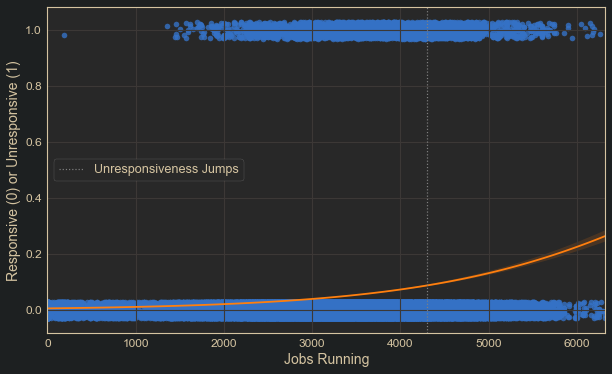

In [91]:
fontsize = 14

fig, ax = plt.subplots(figsize = (10, 6))
sns.regplot(x = 'JOBSRUNNINGBEGIN', 
            y = slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'), 
            data = slurm_testing_JOBSRUNNING, 
            logistic = True, 
            line_kws = {"color": "#FF7F0E"}, 
            y_jitter = 0.03, 
            ax = ax,
            #label = {'scatter':'Actual Values','line':'Logistical Reg Coef: 0.0007'}
)
ax.axvline(x = 4300, color = 'gray', linestyle = ':', label = 'Unresponsiveness Jumps')
plt.legend()
plt.ylabel("Responsive (0) or Unresponsive (1)", fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)
plt.xticks(fontsize = fontsize - 2)
plt.xlabel("Jobs Running", fontsize = fontsize);
plt.savefig('../images/jobs_running_logreg.png', dpi = 600)

## Check the model's calibration
(pretty good)

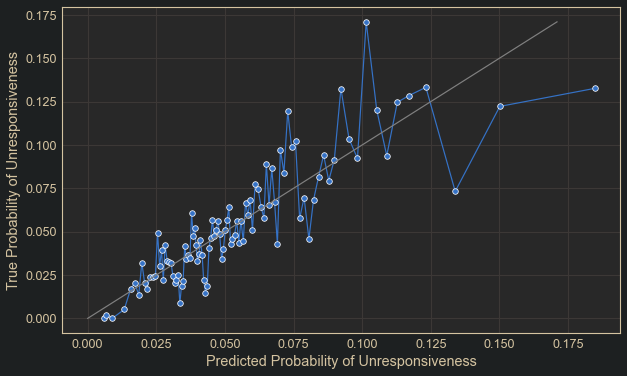

In [79]:
prob_true, prob_pred = sklearn.calibration.calibration_curve(
                                slurm_testing_JOBSRUNNING['UNRESPONSIVE'].astype('int'), 
                                logreg_unresponsive_roll.fittedvalues,
                                strategy = 'quantile',
                                n_bins = 100
                                     )
fig, ax = plt.subplots(figsize = (10,6))
sns.lineplot(x = prob_pred, y = prob_true, ax = ax, marker = 'o')
ax.set(xlabel = 'Predicted Probability of Unresponsiveness',
       ylabel = 'True Probability of Unresponsiveness')
sns.lineplot(x = prob_true, y = prob_true, color = 'gray');
plt.savefig('../images/jobs_running_calibration.png', dpi = 600)

## Look for any thresholds where unresponsiveness jumps
The biggest jump is around 4,300 simultaneous jobs (up to 11.7%)

### Plot 1: 25 Quantiles

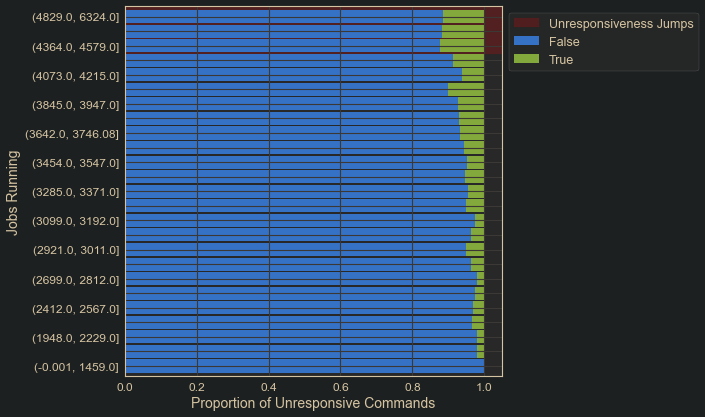

In [107]:
fontsize = 14

slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGINGRP'] = pd.qcut(slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN'], 
                                                           q = 25)
fig, ax = plt.subplots(figsize = (10,6))

(slurm_testing_JOBSRUNNING
         .groupby(['JOBSRUNNINGBEGINGRP', 'UNRESPONSIVE'])
         ['JOBSRUNNINGBEGINGRP']
         .count()/slurm_testing_JOBSRUNNING
                     .groupby('JOBSRUNNINGBEGINGRP')
                     ['JOBSRUNNINGBEGINGRP']
                     .count()
).unstack().plot(kind = 'barh', 
       stacked = True, 
       ax = ax,
       width = 0.9,
       zorder = 1)

# ax.set_xticklabels(ax.get_xticklabels(), 
#                    rotation=45, 
#                    horizontalalignment='right'
#                   )

plt.axhspan(21.4, 26, color='red', alpha=0.2, label = 'Unresponsiveness Jumps', zorder = 0)

plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))

plt.ylabel("Jobs Running", fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)
plt.xticks(fontsize = fontsize - 2)
plt.xlabel("Proportion of Unresponsive Commands", fontsize = fontsize);

for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

plt.tight_layout()
plt.savefig('../images/jobs_running_quantile_probsh.png', dpi = 600)

### Plot 2: 25 evenly distributed bins

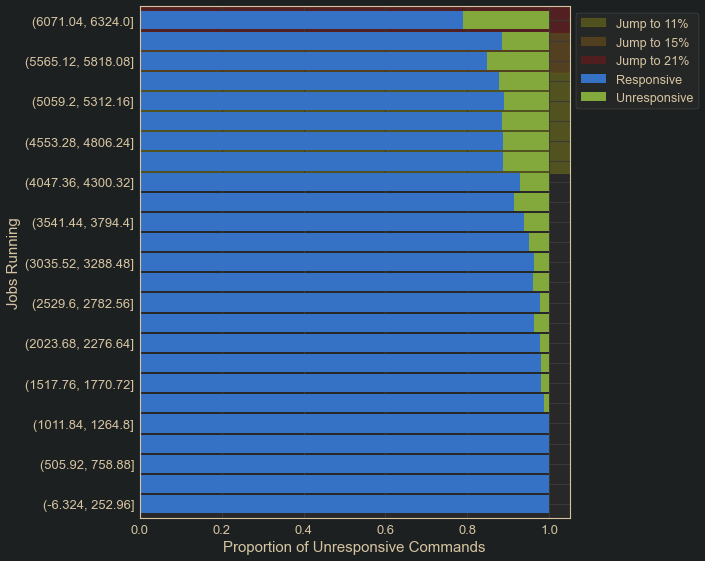

In [81]:
fontsize = 15

slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGINGRP'] = pd.cut(slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN'], 
                                                           bins = 25)
fig, ax = plt.subplots(figsize = (10,8))

(slurm_testing_JOBSRUNNING
         .groupby(['JOBSRUNNINGBEGINGRP', 'UNRESPONSIVE'])
         ['JOBSRUNNINGBEGINGRP']
         .count()/slurm_testing_JOBSRUNNING
                     .groupby('JOBSRUNNINGBEGINGRP')
                     ['JOBSRUNNINGBEGINGRP']
                     .count()
).unstack().plot(kind = 'barh', 
       stacked = True,
       ax = ax,
       width = 0.9,
       zorder = 2)

plt.axhspan(16.4, 21.4, color='yellow', alpha=0.2, zorder = 1)
plt.axhspan(21.4, 23.4, color='orange', alpha=0.2, zorder = 1)
plt.axhspan(23.4, 26, color='red', alpha=0.2, zorder = 1)

plt.legend(labels = ['Jump to 11%', 'Jump to 15%', 'Jump to 21%', 'Responsive', 'Unresponsive'], 
           loc = 'upper left', 
           bbox_to_anchor = (1,1))

plt.ylabel("Jobs Running", fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)
plt.xticks(fontsize = fontsize - 2)
plt.xlabel("Proportion of Unresponsive Commands", fontsize = fontsize);

for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

plt.tight_layout()
plt.savefig('../images/jobs_running_bin_probsh.png', dpi = 600)

### Plot 3: Condense the important stuff from 25 absolute bins

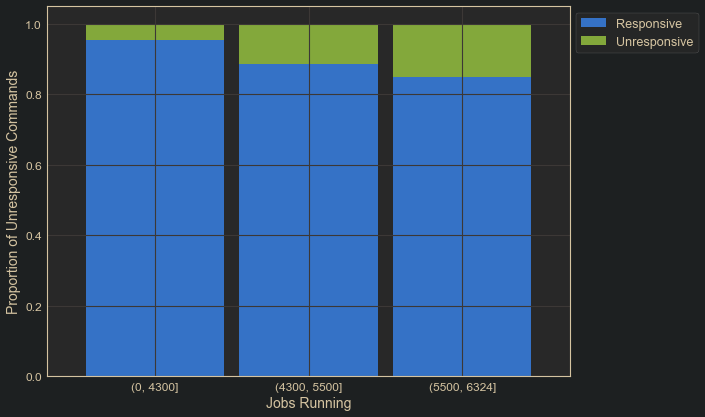

In [82]:
fontsize = 14

slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGINGRP'] = pd.cut(slurm_testing_JOBSRUNNING['JOBSRUNNINGBEGIN'], 
                                                           bins = [0, 4300, 5500, 6324])
fig, ax = plt.subplots(figsize = (10,6))

(slurm_testing_JOBSRUNNING
         .groupby(['JOBSRUNNINGBEGINGRP', 'UNRESPONSIVE'])
         ['BEGIN']
         .count()/slurm_testing_JOBSRUNNING
                     .groupby('JOBSRUNNINGBEGINGRP')
                     ['JOBSRUNNINGBEGINGRP']
                     .count()
).unstack().plot(kind = 'bar', 
       stacked = True, 
       ax = ax,
       width = 0.9)

ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=0 
                  )

plt.legend(labels = ['Responsive', 'Unresponsive'], loc = 'upper left', bbox_to_anchor = (1,1))

plt.ylabel("Proportion of Unresponsive Commands", fontsize = fontsize)
plt.yticks(fontsize = fontsize - 2)
plt.xticks(fontsize = fontsize - 2)
plt.xlabel("Jobs Running", fontsize = fontsize);

plt.tight_layout()
plt.savefig('../images/jobs_running_probs_condensed.png', dpi = 600)

## Identifying the maximum predicted probability of unresponsiveness
About 26.5%

In [83]:
logreg_unresponsive_roll.fittedvalues.max()

0.2645790438037419

# Follow-up: So when do we have a lot of jobs running?

## Mean of jobs simultaneously running
3501 jobs running

In [84]:
slurm_JOBSRUNNING = rollmodel_df(x = testing, 
                                         dt_col = 'BEGIN', 
                                         jobs_running = True, 
                                         filter_jobs = False)

In [85]:
mean_JOBSRUNNING = slurm_JOBSRUNNING['JOBSRUNNINGBEGIN'].mean()
mean_JOBSRUNNING

3500.6465087666497

## Seasonal/Yearlong by week

In [86]:
mean_JOBSRUNNING_by_week = (slurm_JOBSRUNNING
                                    .groupby(
                                            pd.Grouper(key = 'BEGIN', freq = 'W')
                                            ) # Group by week
                                    ['JOBSRUNNINGBEGIN'] # Counting job ids
                                    .mean() # divide count by 168 hours in a week
                                    .reset_index()
                                    .rename(columns = {'BEGIN': 'WEEKOF', 
                                                        'JOBSRUNNINGBEGIN': 'JOBSRUNNINGMEAN'}
                                            )
                         )

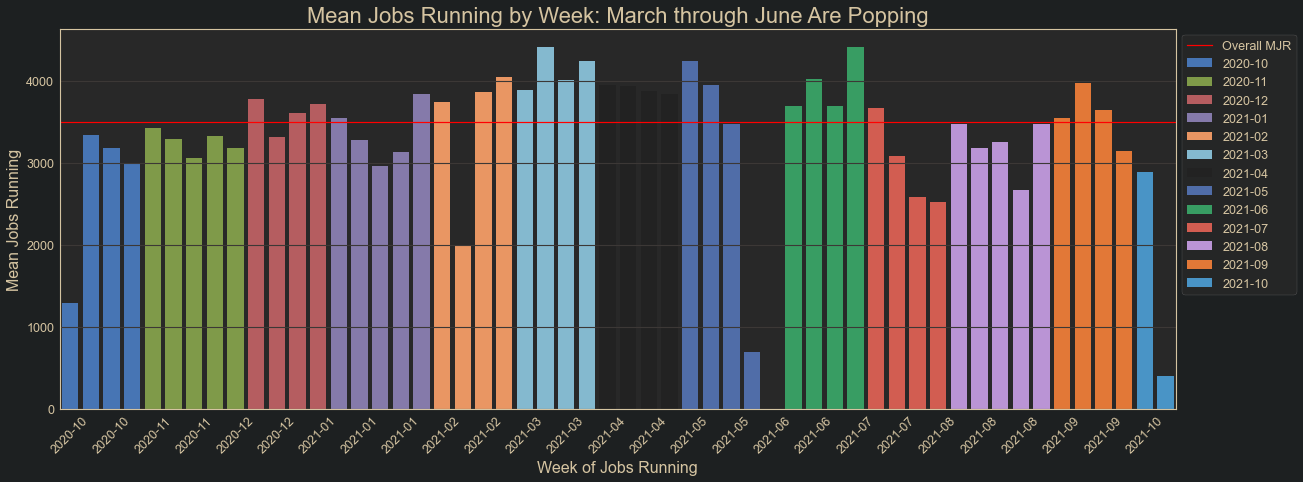

In [87]:
# Plot completions per hour by week, colored by month
fig, ax = plt.subplots(figsize=(20,7))
fontsize = 16
x_dates = mean_JOBSRUNNING_by_week['WEEKOF'].dt.strftime('%Y-%m')

sns.barplot(x = 'WEEKOF',
            y = 'JOBSRUNNINGMEAN',
            data = mean_JOBSRUNNING_by_week,
            ax = ax,
            hue = x_dates,
            dodge = False
           )

ax.axhline(mean_JOBSRUNNING, color = 'red', label = 'Overall MJR')


ax.set_xticklabels(labels=x_dates, 
                   rotation=45, 
                   ha='right')

ax.get_legend().remove()

ax.set_title('Mean Jobs Running by Week: March through June Are Popping',
             fontdict = {'fontsize':22}
            )

plt.xlabel(xlabel = 'Week of Jobs Running', fontsize = fontsize)
plt.ylabel(ylabel = 'Mean Jobs Running', fontsize = fontsize)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.legend(loc = 'upper left', bbox_to_anchor = (1,1));

plt.savefig('../images/jobs_running_by_week.png', dpi = 600)

## Use weeks to estimate whether jobs running has increased on average
It has not. (Though, recall, jobs ended has increased.)

Text(0.5, 1.0, 'Jobs Running Has Not Increased Over the Past Year')

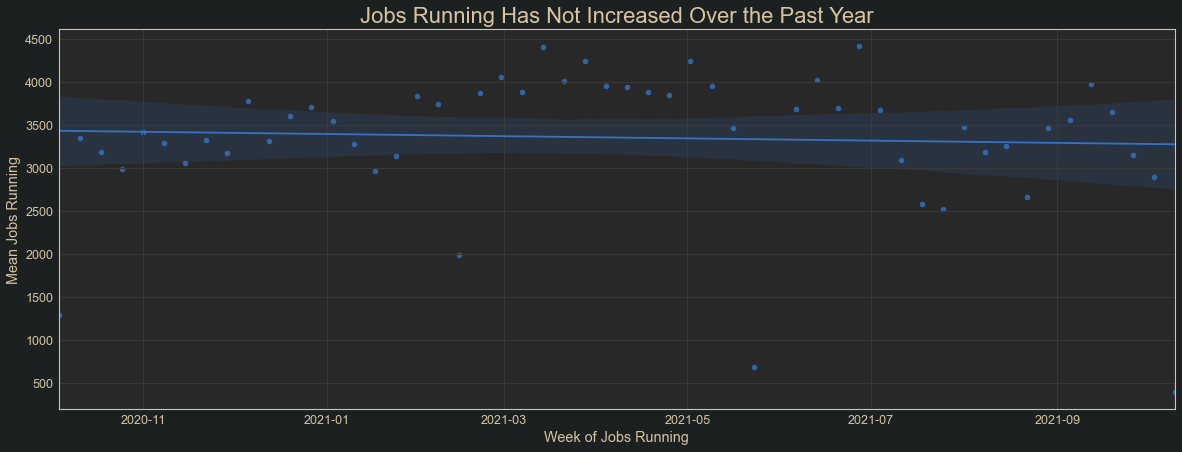

In [88]:
# Plot completions per hour by week along with trendline, which shows gradual increase over the year
fig, ax = plt.subplots(figsize=(20,7))

ax.xaxis.update_units(mean_JOBSRUNNING_by_week['WEEKOF'])

sns.regplot(x = ax.xaxis.convert_units(mean_JOBSRUNNING_by_week['WEEKOF']),
            y = 'JOBSRUNNINGMEAN',
            data = mean_JOBSRUNNING_by_week,
            ax = ax,
            #hue = x_dates,
            #dodge = False
           )

ax.set(xlabel = 'Week of Jobs Running',
       ylabel = 'Mean Jobs Running'
      )
ax.set_title('Jobs Running Has Not Increased Over the Past Year',
      fontdict = {'fontsize' : 22}
      )

## Days
Commented out because the table takes too long to make. Basically, the results look a lot like the weekly chart above.

In [92]:
mean_JOBSRUNNING_by_day = (slurm_JOBSRUNNING
                                    .groupby(
                                            pd.Grouper(key = 'BEGIN', freq = 'D')
                                            ) # Group by week
                                    ['JOBSRUNNINGBEGIN'] # Counting job ids
                                    .mean() # divide count by 168 hours in a week
                                    .reset_index()
                                    .rename(columns = {'BEGIN': 'DAY', 
                                                        'JOBSRUNNINGBEGIN': 'JOBSRUNNINGMEAN'}
                                            )
                         )

In [100]:
# # Plot completions per hour by week, colored by month
# fig, ax = plt.subplots(figsize=(20,7))
# fontsize = 14
# x_dates = mean_JOBSRUNNING_by_day['DAY'].dt.strftime('%Y-%m-%d')

# sns.barplot(x = 'DAY',
#             y = 'JOBSRUNNINGMEAN',
#             data = mean_JOBSRUNNING_by_day,
#             ax = ax,
#             hue = x_dates,
#             dodge = False
#            )


# ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
# ax.get_legend().remove()
# ax.axhline(mean_JOBSRUNNING, color = 'red', label = 'Overall MJR')

# ax.set_title('Mean Jobs Running by Day: March through June Are Popping',
#              fontdict = {'fontsize':22}
#             )

# plt.xlabel('Day of Jobs Running', fontsize = fontsize)
# plt.ylabel('Mean Jobs Running', fontsize = fontsize);

## Weekdays
Early week is highest, but no significantly high days (relative to overall mean)

In [101]:
# Add weekday and weekday number to completions per hour by day
mean_JOBSRUNNING_by_day['WEEKDAY'] = mean_JOBSRUNNING_by_day['DAY'].apply(lambda x: calendar.day_name[x.weekday()])
mean_JOBSRUNNING_by_day['WEEKDAYNUMBER'] = mean_JOBSRUNNING_by_day['DAY'].apply(lambda x: x.weekday()+1)

In [102]:
# Aggregate by weekday
mean_JOBSRUNNING_by_weekday = (mean_JOBSRUNNING_by_day.groupby(['WEEKDAYNUMBER', 'WEEKDAY'], 
                                                              as_index = False)
                                                     ['JOBSRUNNINGMEAN']
                                                     .mean()
                              )

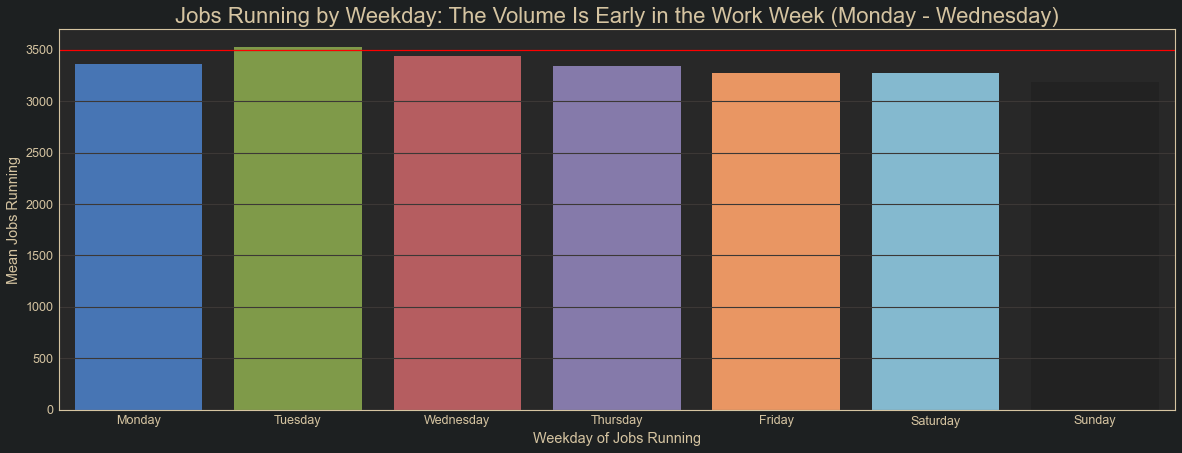

In [103]:
# Plot completions per hour by weekday
fig, ax = plt.subplots(figsize=(20,7))

sns.barplot(x = 'WEEKDAY',
            y = 'JOBSRUNNINGMEAN',
            data = mean_JOBSRUNNING_by_weekday,
            ax = ax,
           )

ax.axhline(mean_JOBSRUNNING, color = 'red')
ax.set(xlabel = 'Weekday of Jobs Running',
       ylabel = 'Mean Jobs Running'
      )
ax.set_title('Jobs Running by Weekday: The Volume Is Early in the Work Week (Monday - Wednesday)',
            fontdict = {'fontsize' : 22}
            );

## Time of day

In [104]:
mean_JOBSRUNNING_by_hour = (slurm_JOBSRUNNING
                                    .groupby(
                                            pd.Grouper(key = 'BEGIN', freq = 'H')
                                            ) # Group by week
                                    ['JOBSRUNNINGBEGIN'] # Counting job ids
                                    .mean() # divide count by 168 hours in a week
                                    .reset_index()
                                    .rename(columns = {'BEGIN': 'HOUR', 
                                                        'JOBSRUNNINGBEGIN': 'JOBSRUNNINGMEAN'}
                                            )
                         )

In [105]:
mean_JOBSRUNNING_by_hour['DAYHOUR'] = mean_JOBSRUNNING_by_hour['HOUR'].dt.hour

mean_JOBSRUNNING_by_dayhour = (mean_JOBSRUNNING_by_hour.groupby('DAYHOUR', 
                                                              as_index = False)
                                                     ['JOBSRUNNINGMEAN']
                                                     .mean()
                              )

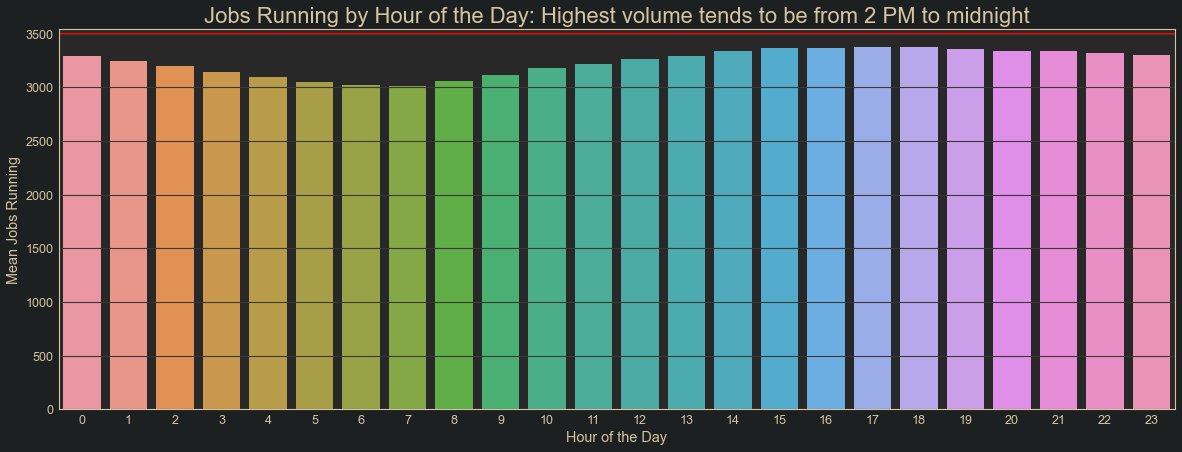

In [106]:
# Plot completions per hour by weekday
fig, ax = plt.subplots(figsize=(20,7))

sns.barplot(x = 'DAYHOUR',
            y = 'JOBSRUNNINGMEAN',
            data = mean_JOBSRUNNING_by_dayhour,
            ax = ax,
           )

ax.axhline(mean_JOBSRUNNING, color = 'red')
ax.set(xlabel = 'Hour of the Day',
       ylabel = 'Mean Jobs Running'
      )
ax.set_title('Jobs Running by Hour of the Day: Highest volume tends to be from 2 PM to midnight',
            fontdict = {'fontsize' : 22}
            )
plt.show()

# Table of Contents (again)
* [Table of Contents](#Table-of-Contents)


* [Imports](#Imports)


* [Functions](#Functions)


* [Read in and filter](#Read-in-and-filter)


* [Model: TESTING vs jobs simultaneously running](#Model:-TESTING-vs-jobs-simultaneously-running)
    * [Plot the model](#Plot-the-model)
    * [Check the model's calibration](#Check-the-model's-calibration)
    * [Look for any thresholds where unresponsiveness jumps](#Look-for-any-thresholds-where-unresponsiveness-jumps)
    * [Identifying the maximum predicted probability of unresponsiveness from the observed data](#Identifying-the-maximum-predicted-probability-of-unresponsiveness)
    
    
 * [Follow-up: So when do we have a lot of jobs running?](#Follow-up:-So-when-do-we-have-a-lot-of-jobs-running?)
     * [Mean of jobs simultaneously running](#Mean-of-jobs-simultaneously-running)
     * [Seasonal/Yearlong by week](#Seasonal/Yearlong-by-week)
     * [Use weeks to estimate whether jobs running has increased on average](#Use-weeks-to-estimate-whether-jobs-running-has-increased-on-average)
     * [Days](#Days)
     * [Weekdays](#Weekdays)
     * [Time of day](#Time-of-day)